# Create historical odds and fixtures data for all seasons in FFS data

For convenience we create the dataset of fixtures and odds from 2011-12 to 2019-20 in this notebook rather than using functions.

## Set-up

In [1]:
import getpass
from functools import reduce
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from s3fs import S3FileSystem
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
pd.options.display.max_columns = None

In [3]:
os.chdir('../..')

## Load fixture and odds data

In [4]:
fixture_and_odds = pd.read_parquet('data/processed/fixture_and_odds_2011_to_2020.parquet')
print(fixture_and_odds.shape)
fixture_and_odds.head()

(3420, 7)


,home_team,away_team,gw,season,home_win,draw,away_win
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05


Find example of a double gameweek

In [5]:
fixture_and_odds[
    (fixture_and_odds['season'] == '2017-2018') & 
    (fixture_and_odds['gw'] == 37)
].shape

(16, 7)

In [6]:
fixture_and_odds.isnull().sum()

home_team     0
away_team     0
gw            0
season        0
home_win     28
draw         28
away_win     28
dtype: int64

### Impute null odds

In [7]:
fixture_and_odds[fixture_and_odds['home_win'].isnull()]['season'].unique()

array(['2015-2016'], dtype=object)

Nulls only occur in the 2015-16 season. We will impute them with the mean odds for the respective home and away teams in the 2014-15 season. This avoids any data leakage issues.

In [8]:
mean_home_win_odds = fixture_and_odds[fixture_and_odds['season'] == '2014-2015'].groupby('home_team')['home_win'].mean().reset_index().rename(
    columns={'home_win': 'home_win_mean', 'home_team': 'team'}
)
mean_home_win_odds.head()

,team,home_win_mean
0,Arsenal,0.582632
1,Aston Villa,2.721053
2,Burnley,2.934211
3,Chelsea,0.439474
4,Crystal Palace,2.197895


In [9]:
mean_away_win_odds = fixture_and_odds[fixture_and_odds['season'] == '2014-2015'].groupby('away_team')['away_win'].mean().reset_index().rename(
    columns={'away_win': 'away_win_mean', 'away_team': 'team'}
)
mean_away_win_odds.head()

,team,away_win_mean
0,Arsenal,1.349474
1,Aston Villa,5.374737
2,Burnley,6.011053
3,Chelsea,0.835789
4,Crystal Palace,4.845789


In [10]:
mean_odds_1415 = mean_home_win_odds.merge(mean_away_win_odds, on='team')
mean_odds_1415.head()

,team,home_win_mean,away_win_mean
0,Arsenal,0.582632,1.349474
1,Aston Villa,2.721053,5.374737
2,Burnley,2.934211,6.011053
3,Chelsea,0.439474,0.835789
4,Crystal Palace,2.197895,4.845789


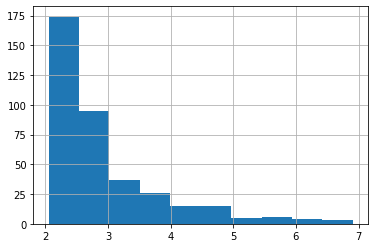

In [11]:
fixture_and_odds[fixture_and_odds['season'] == '2014-2015']['draw'].hist()

In [12]:
mean_draw_odds = fixture_and_odds[fixture_and_odds['season'] == '2014-2015']['draw'].mean()
mean_draw_odds

2.9499473684210527

Fill null draw odds

In [13]:
fixture_and_odds['draw'].fillna(mean_draw_odds, inplace=True)

Fill null home odds

In [14]:
fixture_and_odds = fixture_and_odds.merge(mean_odds_1415, left_on='home_team', right_on='team', how='left')
fixture_and_odds.head()

,home_team,away_team,gw,season,home_win,draw,away_win,team,home_win_mean,away_win_mean
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10,NaN,NaN,NaN
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08,NaN,NaN,NaN
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90,Liverpool,0.825263,1.518947
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44,Queens Park Rangers,2.939474,6.456316
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05,NaN,NaN,NaN


In [15]:
fixture_and_odds['home_win'] = np.where(
    fixture_and_odds['home_win'].isnull(),
    fixture_and_odds['home_win_mean'],
    fixture_and_odds['home_win']
)

fixture_and_odds.drop(columns=['team', 'home_win_mean', 'away_win_mean'], inplace=True)
fixture_and_odds.head()

,home_team,away_team,gw,season,home_win,draw,away_win
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05


Fill null away odds

In [16]:
fixture_and_odds = fixture_and_odds.merge(mean_odds_1415, left_on='away_team', right_on='team', how='left')
fixture_and_odds.head()

,home_team,away_team,gw,season,home_win,draw,away_win,team,home_win_mean,away_win_mean
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10,NaN,NaN,NaN
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08,Aston Villa,2.721053,5.374737
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90,Sunderland,2.661053,5.116316
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44,NaN,NaN,NaN
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05,NaN,NaN,NaN


In [17]:
fixture_and_odds['away_win'] = np.where(
    fixture_and_odds['away_win'].isnull(),
    fixture_and_odds['away_win_mean'],
    fixture_and_odds['away_win']
)

fixture_and_odds.drop(columns=['team', 'home_win_mean', 'away_win_mean'], inplace=True)
fixture_and_odds.head()

,home_team,away_team,gw,season,home_win,draw,away_win
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05


In [18]:
fixture_and_odds.isnull().sum()

home_team    0
away_team    0
gw           0
season       0
home_win     4
draw         0
away_win     1
dtype: int64

Still some fixtures with nulls odds

In [19]:
fixture_and_odds[fixture_and_odds['home_win'].isnull() | fixture_and_odds['away_win'].isnull()]

,home_team,away_team,gw,season,home_win,draw,away_win
1522,Norwich City,Crystal Palace,1,2015-2016,NaN,2.949947,4.845789
1534,Sunderland,Norwich City,2,2015-2016,2.661053,2.949947,NaN
1700,Norwich City,Aston Villa,19,2015-2016,NaN,2.949947,5.374737
1816,Watford,Stoke City,31,2015-2016,NaN,2.949947,4.071579
1850,Bournemouth,Liverpool,34,2015-2016,NaN,2.949947,1.518947


In [20]:
set(fixture_and_odds[fixture_and_odds['home_win'].isnull()]['home_team'])

{'Bournemouth', 'Norwich City', 'Watford'}

In [21]:
set(fixture_and_odds[fixture_and_odds['away_win'].isnull()]['away_team'])

{'Norwich City'}

These were the promoted sides. In a later step we can used the mean odds for the promoted teams in the 2014-15 season for imputation.

## Reformat fixture data

In [22]:
fixture_and_odds.head()

,home_team,away_team,gw,season,home_win,draw,away_win
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05


In [23]:
# Amend fixture data so that it is at a team level and specifies whether that team played home or away. This doubles the size of the dataset.
teams_in_gw_1 = fixture_and_odds.copy()
teams_in_gw_1['team_name'] = teams_in_gw_1['home_team']
teams_in_gw_1['team_name_opponent'] = teams_in_gw_1['away_team']
teams_in_gw_1['was_home'] = True

teams_in_gw_2 = fixture_and_odds.copy()
teams_in_gw_2['team_name'] = teams_in_gw_2['away_team']
teams_in_gw_2['team_name_opponent'] = teams_in_gw_2['home_team']
teams_in_gw_2['was_home'] = False

teams_in_gw = teams_in_gw_1.append(teams_in_gw_2)
teams_in_gw.head()

,home_team,away_team,gw,season,home_win,draw,away_win,team_name,team_name_opponent,was_home
0,Blackburn Rovers,Wolverhampton Wanderers,1,2011-2012,1.37,2.17,2.10,Blackburn Rovers,Wolverhampton Wanderers,True
1,Fulham,Aston Villa,1,2011-2012,0.95,2.32,3.08,Fulham,Aston Villa,True
2,Liverpool,Sunderland,1,2011-2012,0.44,3.18,6.90,Liverpool,Sunderland,True
3,Queens Park Rangers,Bolton Wanderers,1,2011-2012,1.19,2.21,2.44,Queens Park Rangers,Bolton Wanderers,True
4,Wigan Athletic,Norwich City,1,2011-2012,1.33,2.27,2.05,Wigan Athletic,Norwich City,True


In [24]:
teams_in_gw.shape

(6840, 10)

In [25]:
teams_in_gw['win_odds'] = np.where(
    teams_in_gw['was_home'],
    teams_in_gw['home_win'],
    teams_in_gw['away_win']
)

teams_in_gw['lose_odds'] = np.where(
    teams_in_gw['was_home'],
    teams_in_gw['away_win'],
    teams_in_gw['home_win']
)

In [26]:
teams_in_gw.drop(columns=['home_team', 'away_team', 'home_win', 'away_win'], inplace=True)

In [27]:
teams_in_gw.rename(columns={'draw': 'draw_odds'}, inplace=True)

In [28]:
teams_in_gw.head()

,gw,season,draw_odds,team_name,team_name_opponent,was_home,win_odds,lose_odds
0,1,2011-2012,2.17,Blackburn Rovers,Wolverhampton Wanderers,True,1.37,2.10
1,1,2011-2012,2.32,Fulham,Aston Villa,True,0.95,3.08
2,1,2011-2012,3.18,Liverpool,Sunderland,True,0.44,6.90
3,1,2011-2012,2.21,Queens Park Rangers,Bolton Wanderers,True,1.19,2.44
4,1,2011-2012,2.27,Wigan Athletic,Norwich City,True,1.33,2.05


## Add further team details

In [29]:
team_data = pd.read_csv('data/external/team_season_data.csv')
print(team_data.shape)
team_data.head()

(200, 6)


,team,team_name,promoted_side,top_6_last_season,season,team_name_ffs
0,1.0,Arsenal,0,1,2016-17,Arsenal
1,2.0,Bournemouth,0,0,2016-17,Bournemouth
2,3.0,Burnley,1,0,2016-17,Burnley
3,4.0,Chelsea,0,0,2016-17,Chelsea
4,5.0,Crystal Palace,0,0,2016-17,Crystal Palace


In [30]:
team_data['season'] = team_data['season'].apply(lambda x: x.replace('-','-20'))

In [31]:
team_data.drop(columns=['team', 'team_name'], inplace=True)
team_data.rename(columns={'team_name_ffs': 'team_name'}, inplace=True)

In [32]:
team_data_opponent = team_data.copy()
team_data_opponent.columns = [col + '_opponent' for col in team_data_opponent.columns]
team_data_opponent.rename(columns={'season_opponent': 'season'}, inplace=True)
team_data_opponent.head()

,promoted_side_opponent,top_6_last_season_opponent,season,team_name_opponent
0,0,1,2016-2017,Arsenal
1,0,0,2016-2017,Bournemouth
2,1,0,2016-2017,Burnley
3,0,0,2016-2017,Chelsea
4,0,0,2016-2017,Crystal Palace


In [33]:
teams_in_gw.head()

,gw,season,draw_odds,team_name,team_name_opponent,was_home,win_odds,lose_odds
0,1,2011-2012,2.17,Blackburn Rovers,Wolverhampton Wanderers,True,1.37,2.10
1,1,2011-2012,2.32,Fulham,Aston Villa,True,0.95,3.08
2,1,2011-2012,3.18,Liverpool,Sunderland,True,0.44,6.90
3,1,2011-2012,2.21,Queens Park Rangers,Bolton Wanderers,True,1.19,2.44
4,1,2011-2012,2.27,Wigan Athletic,Norwich City,True,1.33,2.05


In [34]:
teams_in_gw = teams_in_gw.merge(
    team_data_opponent,
    on=['team_name_opponent', 'season'],
    how='left'
)

In [35]:
teams_in_gw = teams_in_gw.merge(
    team_data,
    on=['team_name', 'season'],
    how='left'
)

In [36]:
teams_in_gw.head()

,gw,season,draw_odds,team_name,team_name_opponent,was_home,win_odds,lose_odds,promoted_side_opponent,top_6_last_season_opponent,promoted_side,top_6_last_season
0,1,2011-2012,2.17,Blackburn Rovers,Wolverhampton Wanderers,True,1.37,2.10,0,0,0,0
1,1,2011-2012,2.32,Fulham,Aston Villa,True,0.95,3.08,0,0,0,0
2,1,2011-2012,3.18,Liverpool,Sunderland,True,0.44,6.90,0,0,0,1
3,1,2011-2012,2.21,Queens Park Rangers,Bolton Wanderers,True,1.19,2.44,0,0,1,0
4,1,2011-2012,2.27,Wigan Athletic,Norwich City,True,1.33,2.05,1,0,0,0


### Impute null odds for promoted sides

In [37]:
teams_in_gw.isnull().sum()

gw                            0
season                        0
draw_odds                     0
team_name                     0
team_name_opponent            0
was_home                      0
win_odds                      5
lose_odds                     5
promoted_side_opponent        0
top_6_last_season_opponent    0
promoted_side                 0
top_6_last_season             0
dtype: int64

In [38]:
teams_in_gw[teams_in_gw['win_odds'].isnull()]

,gw,season,draw_odds,team_name,team_name_opponent,was_home,win_odds,lose_odds,promoted_side_opponent,top_6_last_season_opponent,promoted_side,top_6_last_season
1522,1,2015-2016,2.949947,Norwich City,Crystal Palace,True,NaN,4.845789,0,0,1,0
1700,19,2015-2016,2.949947,Norwich City,Aston Villa,True,NaN,5.374737,0,0,1,0
1816,31,2015-2016,2.949947,Watford,Stoke City,True,NaN,4.071579,0,0,1,0
1850,34,2015-2016,2.949947,Bournemouth,Liverpool,True,NaN,1.518947,0,1,1,0
4954,2,2015-2016,2.949947,Norwich City,Sunderland,False,NaN,2.661053,0,0,1,0


In [39]:
promoted_side_win_odds_1415 = teams_in_gw[
    (teams_in_gw['season'] == '2014-2015') & 
    (teams_in_gw['promoted_side']) &
    (teams_in_gw['was_home'] == True)
]['win_odds'].mean()

promoted_side_win_odds_1415

2.644035087719298

In [40]:
promoted_side_lose_odds_1415 = teams_in_gw[
    (teams_in_gw['season'] == '2014-2015') & 
    (teams_in_gw['promoted_side']) &
    (teams_in_gw['was_home'] == False)
]['win_odds'].mean()

promoted_side_lose_odds_1415

5.81140350877193

In [41]:
teams_in_gw['win_odds'].fillna(promoted_side_win_odds_1415, inplace=True)
teams_in_gw['lose_odds'].fillna(promoted_side_lose_odds_1415, inplace=True)

In [42]:
teams_in_gw.isnull().sum()

gw                            0
season                        0
draw_odds                     0
team_name                     0
team_name_opponent            0
was_home                      0
win_odds                      0
lose_odds                     0
promoted_side_opponent        0
top_6_last_season_opponent    0
promoted_side                 0
top_6_last_season             0
dtype: int64

In [43]:
# Double gameweeks
teams_in_gw[teams_in_gw['season'] == '2017-2018'].groupby(['gw', 'team_name']).count()['season'][
    teams_in_gw[teams_in_gw['season'] == '2017-2018'].groupby(['gw', 'team_name']).count()['season'] == 2
]

gw  team_name               
22  Tottenham Hotspur           2
    West Ham United             2
34  Bournemouth                 2
    Brighton and Hove Albion    2
    Burnley                     2
    Chelsea                     2
    Leicester City              2
    Manchester United           2
    Southampton                 2
    Tottenham Hotspur           2
37  Arsenal                     2
    Brighton and Hove Albion    2
    Chelsea                     2
    Huddersfield Town           2
    Leicester City              2
    Manchester City             2
    Manchester United           2
    Newcastle United            2
    Southampton                 2
    Swansea City                2
    Tottenham Hotspur           2
    West Ham United             2
Name: season, dtype: int64

In [44]:
teams_in_gw[
    (teams_in_gw['season'] == '2017-2018') & (teams_in_gw['gw'] == 37) & (teams_in_gw['team_name'] == 'Arsenal')
]

,gw,season,draw_odds,team_name,team_name_opponent,was_home,win_odds,lose_odds,promoted_side_opponent,top_6_last_season_opponent,promoted_side,top_6_last_season
2642,37,2017-2018,3.93,Arsenal,Burnley,True,0.43,6.86,0,0,0,1
6065,37,2017-2018,2.87,Arsenal,Leicester City,False,0.96,2.86,0,0,0,1


We want to collapse these cases into a single row. We will do the following aggregations:

- `draw_odds`: mean
- `win_odds`: mean
- `lose_odds`: mean
- `was_home`: sum (rename to number of home matches)
- `promoted_side_opponent`: sum (number of)
- `top_6_last_season_opponent`: sum (number of)
- `promoted_side`: mean (get original value back)
- `top_6_last_season`: mean (get original value back)
- Also add `number_of_matches` to identify double gameweeks

In [45]:
teams_in_gw.rename(
    columns={
        'was_home': 'number_of_home_matches',
        'promoted_side_opponent': 'number_of_promoted_side_opponent',
        'top_6_last_season_opponent': 'number_of_top_6_last_season_opponent',
    },
    inplace=True
)

In [46]:
teams_in_gw['number_of_matches'] = 1

In [47]:
teams_in_gw.head()

,gw,season,draw_odds,team_name,team_name_opponent,number_of_home_matches,win_odds,lose_odds,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
0,1,2011-2012,2.17,Blackburn Rovers,Wolverhampton Wanderers,True,1.37,2.10,0,0,0,0,1
1,1,2011-2012,2.32,Fulham,Aston Villa,True,0.95,3.08,0,0,0,0,1
2,1,2011-2012,3.18,Liverpool,Sunderland,True,0.44,6.90,0,0,0,1,1
3,1,2011-2012,2.21,Queens Park Rangers,Bolton Wanderers,True,1.19,2.44,0,0,1,0,1
4,1,2011-2012,2.27,Wigan Athletic,Norwich City,True,1.33,2.05,1,0,0,0,1


In [48]:
agg_dict = {
    'draw_odds': 'mean',
    'win_odds': 'mean',
    'lose_odds': 'mean',
    'number_of_home_matches': 'sum',
    'number_of_promoted_side_opponent': 'sum',
    'number_of_top_6_last_season_opponent': 'sum',
    'promoted_side': 'mean',
    'top_6_last_season': 'mean',
    'number_of_matches': 'sum'
}

teams_in_gw_agg = teams_in_gw.groupby(['season', 'gw', 'team_name']).agg(agg_dict).reset_index()

Check Arsenal double gameweek from above

In [49]:
teams_in_gw_agg.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,1
1,2011-2012,1,Aston Villa,2.32,3.08,0.95,0.0,0,0,0,0,1
2,2011-2012,1,Blackburn Rovers,2.17,1.37,2.10,1.0,0,0,0,0,1
3,2011-2012,1,Bolton Wanderers,2.21,2.44,1.19,0.0,1,0,0,0,1
4,2011-2012,1,Chelsea,2.39,0.90,3.17,0.0,0,0,0,1,1


In [50]:
teams_in_gw_agg[
    (teams_in_gw_agg['season'] == '2017-2018') & (teams_in_gw_agg['gw'] == 37) & (teams_in_gw_agg['team_name'] == 'Arsenal')
]

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
5152,2017-2018,37,Arsenal,3.4,0.695,4.86,1.0,0,0,0,1,2


Now a single row!

In [51]:
teams_in_gw_agg.shape

(6684, 12)

In [52]:
# Double gameweeks with both fixtures at home
teams_in_gw_agg[teams_in_gw_agg['number_of_home_matches'] == teams_in_gw_agg['number_of_home_matches'].max()]

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
394,2011-2012,20,Tottenham Hotspur,3.580,0.425,7.620,2.0,0,0,0,1,2
665,2011-2012,35,Aston Villa,2.315,1.095,2.590,2.0,0,0,0,0,2
688,2011-2012,36,Chelsea,3.460,0.440,6.250,2.0,1,0,0,1,2
697,2011-2012,36,Stoke City,2.395,2.725,1.100,2.0,0,1,0,0,2
1054,2012-2013,16,Sunderland,2.630,2.990,1.915,2.0,1,1,0,0,2
1241,2012-2013,26,Liverpool,3.795,0.400,7.135,2.0,0,0,0,0,2
1366,2012-2013,33,Arsenal,3.845,0.470,8.105,2.0,0,0,0,1,2
1486,2013-2014,1,Chelsea,5.380,0.240,12.440,2.0,1,0,0,1,2
2074,2013-2014,31,Newcastle United,2.345,1.650,2.225,2.0,1,1,0,0,2
2082,2013-2014,31,West Ham United,2.545,2.455,1.525,2.0,1,1,0,0,2


In [53]:
teams_in_gw[
    (teams_in_gw['season'] == '2018-2019') & (teams_in_gw['gw'] == 34) & (teams_in_gw['team_name'] == 'Brighton and Hove Albion')
]

,gw,season,draw_odds,team_name,team_name_opponent,number_of_home_matches,win_odds,lose_odds,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
2987,34,2018-2019,2.27,Brighton and Hove Albion,Bournemouth,True,1.31,2.39,0,0,0,0,1
2995,34,2018-2019,2.26,Brighton and Hove Albion,Cardiff City,True,1.00,3.43,1,0,0,0,1


## Double gameweek flag

In [54]:
teams_in_gw_agg.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,1
1,2011-2012,1,Aston Villa,2.32,3.08,0.95,0.0,0,0,0,0,1
2,2011-2012,1,Blackburn Rovers,2.17,1.37,2.10,1.0,0,0,0,0,1
3,2011-2012,1,Bolton Wanderers,2.21,2.44,1.19,0.0,1,0,0,0,1
4,2011-2012,1,Chelsea,2.39,0.90,3.17,0.0,0,0,0,1,1


In [55]:
teams_in_gw_agg['number_of_matches'].value_counts()

1    6528
2     156
Name: number_of_matches, dtype: int64

In [56]:
teams_in_gw_agg['double_gameweek'] = np.where(
    teams_in_gw_agg['number_of_matches'] == 2,
    1,
    0
)

In [57]:
teams_in_gw_agg[
    (teams_in_gw_agg['season'] == '2017-2018') & (teams_in_gw_agg['gw'] == 37) & (teams_in_gw_agg['team_name'] == 'Arsenal')
]

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,number_of_matches,double_gameweek
5152,2017-2018,37,Arsenal,3.4,0.695,4.86,1.0,0,0,0,1,2,1


In [58]:
teams_in_gw_agg.drop('number_of_matches', axis=1, inplace=True)

## Next match/gameweek features

In [59]:
teams_in_gw_agg.sort_values(['season', 'team_name', 'gw'], inplace=True)
teams_in_gw_agg.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0
18,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0
38,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0
58,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0
78,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0


Group by `team_name` only (not `season` as well) so that gameweek 1 predictions rely on previous season data. GW38 of latest season will have nulls but we can drop these.

In [60]:
for feature in [
    'draw_odds', 
    'win_odds', 
    'lose_odds', 
    'number_of_home_matches', 
    'number_of_promoted_side_opponent', 
    'number_of_top_6_last_season_opponent',
    'double_gameweek'
]:
    teams_in_gw_agg[f'next_gameweek_{feature}'] = teams_in_gw_agg.groupby(['team_name'])[feature].shift(-1)

In [61]:
teams_in_gw_agg.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0,2.26,1.32,2.09,1.0,0.0,1.0,0.0
18,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0,3.93,7.28,0.36,0.0,0.0,1.0,0.0
38,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0,3.63,0.36,8.10,1.0,1.0,0.0,0.0
58,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0,2.38,1.00,2.79,0.0,0.0,0.0,0.0
78,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0,3.75,0.36,7.63,1.0,0.0,0.0,0.0


Check `next_gameweek_double_gameweek` for Arsenal example

In [62]:
teams_in_gw_agg[
    (teams_in_gw_agg['season'] == '2017-2018') & (teams_in_gw_agg['gw'] == 36) & (teams_in_gw_agg['team_name'] == 'Arsenal')
]

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
5132,2017-2018,36,Arsenal,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0


In [63]:
teams_in_gw_agg[
    (teams_in_gw_agg['season'] == '2019-2020') & (teams_in_gw_agg['gw'] == 38) & (teams_in_gw_agg['team_name'] == 'Arsenal')
]

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
6664,2019-2020,38,Arsenal,2.81,1.01,2.61,1.0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
teams_in_gw_agg.isnull().sum()

season                                                 0
gw                                                     0
team_name                                              0
draw_odds                                              0
win_odds                                               0
lose_odds                                              0
number_of_home_matches                                 0
number_of_promoted_side_opponent                       0
number_of_top_6_last_season_opponent                   0
promoted_side                                          0
top_6_last_season                                      0
double_gameweek                                        0
next_gameweek_draw_odds                               34
next_gameweek_win_odds                                34
next_gameweek_lose_odds                               34
next_gameweek_number_of_home_matches                  34
next_gameweek_number_of_promoted_side_opponent        34
next_gameweek_number_of_top_6_l

In [65]:
teams_in_gw_agg.shape

(6684, 19)

In [67]:
teams_in_gw_agg[teams_in_gw_agg['next_gameweek_double_gameweek'].isnull()]['gw'].unique()

array([38])

## Save

In [68]:
teams_in_gw_agg.to_parquet('data/processed/formatted_fixture_and_odds_features_2011_to_2020.parquet', index=False)